In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from datetime import datetime as dt
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append("..")
from src.data import utils as u

/Users/mjain/Dev_DoSomething/sms_project/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## Build/validate target variable

Load dataframe.

At the most basic level, we would like to understand if a user responded at all in 2018. To hone in on this, we can look at how many messages were sent out to the user (unique number of outbound message ids) and how many messages were income (unique number of inbound message ids). So, for each user, we will calculate a binary based on the ratio of inbound : outbound where 0 means no responses and 1 means at least 1 response.

We could also create a version that varies the binary based on the percent responded to.

In [6]:
df_gambit = pd.read_csv('../data/raw/gambit_2018.csv.gz', compression='gzip', nrows=2000000)

In [7]:
def non_null_unique(ser):
    return len(ser[ser.notnull()].unique())

df_grouped = df_gambit.groupby('user_id').agg({'outbound_message_id': lambda x: len(x.unique()),
                                 'inbound_message_id': non_null_unique})

In [8]:
df_grouped['percent_response'] = df_grouped['inbound_message_id'] / df_grouped['outbound_message_id']

In [9]:
df_grouped['percent_response'].describe()

count    98013.000000
mean         0.008915
std          0.034889
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.857143
Name: percent_response, dtype: float64

In [8]:
df_grouped['target'] = (df_grouped['inbound_message_id'] > 0) * 1

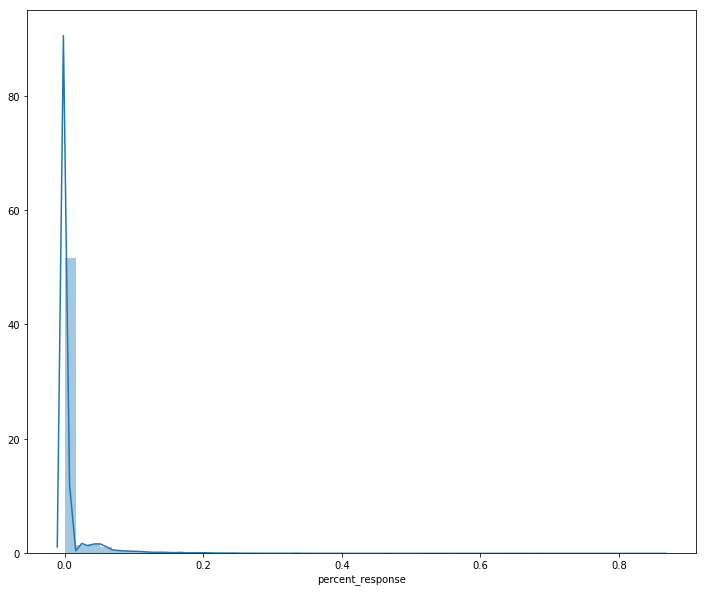

In [14]:
fig, ax = plt.subplots()
sns.distplot(df_grouped['percent_response'], ax=ax, bins=50)
fig.set_size_inches(12, 10)

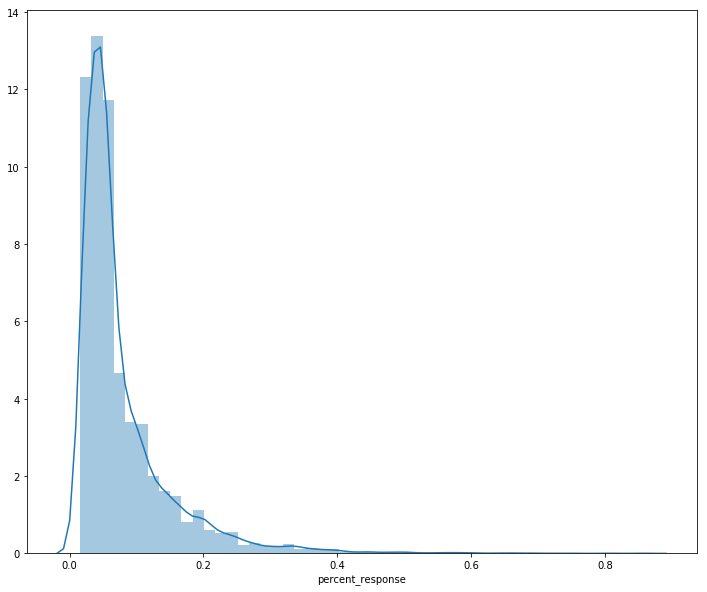

In [16]:
fig1, ax1 = plt.subplots()
sns.distplot(df_grouped[df_grouped['percent_response'] > 0]['percent_response'], ax=ax1, bins=50)
fig1.set_size_inches(12, 10)

In [15]:
# df_grouped['group'] = pd.cut(df_grouped['percent_response'], [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], labels=[
#     '0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%'
# ])
# df_grouped['group'].value_counts()

## Build user characteristics

This will come from two sources: 1) northstar containing user profile and 2) signups/posts/reportbacks containing information about activity

In [16]:
conn = u.load_connection()

In [31]:
user_ids = u.sql_stringify_list(list(df_grouped.index.values))

In [42]:
user_info_sql = '''
SELECT
	2018 - date_part('YEAR', u.birthdate) AS age,
	EXTRACT(DAY FROM now() - u.created_at) AS length_of_membership_days,
	u.source,
	u.state,
	u.northstar_id,
    s.id as signup_id,
    s.campaign_id,
    s.created_at as signup_created_at,
    r.post_created_at,
    r.post_id,
    r.post_type
FROM public.users u
LEFT JOIN (
	SELECT northstar_id, campaign_id, max(id) as id, max(created_at) as created_at 
    FROM signups 
    WHERE created_at >= '2018-01-01'
    AND created_at < '2019-01-01'
    GROUP BY northstar_id, campaign_id) s
ON u.northstar_id = s.northstar_id
LEFT JOIN (
    SELECT northstar_id, signup_id, min(post_created_at) as post_created_at, min(post_id) as post_id, min(post_type) AS post_type 
    FROM reportbacks 
    GROUP BY northstar_id, signup_id) r
ON u.northstar_id = r.northstar_id
    and s.id = r.signup_id
WHERE u.northstar_id in ({});
'''.format(user_ids)

df_user_info = pd.read_sql(user_info_sql, conn)

In [88]:
df_user_info.columns

Index(['age', 'length_of_membership_days', 'source', 'state', 'northstar_id',
       'signup_id', 'campaign_id', 'signup_created_at', 'post_created_at',
       'post_id', 'post_type'],
      dtype='object')

In [399]:
def top_val(ser):
    if len(ser.value_counts()):
        return ser.value_counts().index[0]
    return None

df_user_activity = df_user_info.groupby('northstar_id').agg({
    'signup_id': {'num_signups': non_null_unique},
    'signup_created_at': {'most_recent_signup': 'max'},
    'post_id': {'num_rbs': non_null_unique},
    'post_created_at': {'most_recent_post': 'max'},
    'post_type': {'post_type': top_val}
})

/Users/mjain/Dev_DoSomething/sms_project/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [400]:
df_user_activity.columns = df_user_activity.columns.droplevel()

In [409]:
df_user_activity.reset_index(inplace=True)

In [410]:
df_user_final = pd.merge(df_user_activity, df_user_info[~(df_user_info[
    ['age', 'length_of_membership_days', 'source', 'state', 'northstar_id']
].duplicated(keep='first'))][['age', 'length_of_membership_days', 'source', 'state', 'northstar_id']], how='left', on='northstar_id')

## Combine features + target

In [411]:
df_grouped.reset_index(inplace=True)

In [412]:
df_grouped.rename(columns={'user_id': 'northstar_id'}, inplace=True)

In [413]:
df_final = pd.merge(df_grouped[['northstar_id', 'percent_response', 'target']], df_user_final, on='northstar_id')

In [414]:
df_final.columns

Index(['northstar_id', 'percent_response', 'target', 'num_signups',
       'most_recent_signup', 'num_rbs', 'most_recent_post', 'Active',
       'Inactive', 'Less Active', 'no_post', 'photo', 'share-social', 'text',
       'voter-reg', 'age', 'length_of_membership_days', 'source', 'state'],
      dtype='object')

Remove missing values.

In [417]:
# remove missing vals
df_final = df_final[~(df_final['age'].isnull())]
df_final = df_final[~(df_final['state'].isnull())]
df_final = df_final[~(df_final['source'].isnull())]

In [422]:
df_final.describe()

,percent_response,target,num_signups,num_rbs,Active,Inactive,Less Active,no_post,photo,share-social,...,niche,niche-import-service,phoenix,sms,MIDDLE ATLANTIC,MIDWEST,NEW ENGLAND,SOUTH,SOUTHWEST,WEST
count,16654.000000,16654.000000,16654.000000,16654.000000,16654.000000,16654.000000,16654.000000,16654.000000,16654.000000,16654.000000,...,16654.000000,16654.000000,16654.000000,16654.000000,16654.000000,16654.000000,16654.00000,16654.000000,16654.000000,16654.000000
mean,0.015468,0.202234,0.305933,0.042572,0.058785,0.848205,0.093011,0.964213,0.006125,0.007986,...,0.052240,0.000180,0.610904,0.336196,0.140507,0.160262,0.06539,0.270806,0.145791,0.212021
std,0.047408,0.401678,0.999077,0.246615,0.235228,0.358833,0.290456,0.185765,0.078022,0.089010,...,0.222517,0.013421,0.487560,0.472421,0.347522,0.366860,0.24722,0.444389,0.352907,0.408752
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000
max,1.500000,1.000000,26.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [424]:
df_final.head()

,northstar_id,percent_response,target,num_signups,most_recent_signup,num_rbs,most_recent_post,Active,Inactive,Less Active,...,niche,niche-import-service,phoenix,sms,MIDDLE ATLANTIC,MIDWEST,NEW ENGLAND,SOUTH,SOUTHWEST,WEST
0,54fa272b469c64d7068b4567,0.0,0,1.0,2018-05-15 19:25:41,0.0,NaT,0,0,1,...,0,0,1,0,1,0,0,0,0,0
1,54fa272b469c64d8068b4568,0.0,0,0.0,NaT,0.0,NaT,0,1,0,...,0,0,0,1,1,0,0,0,0,0
2,54fa272b469c64d8068b456b,0.0,0,0.0,NaT,0.0,NaT,0,1,0,...,0,0,0,1,0,0,0,1,0,0
3,54fa272c469c64d7068b456d,0.0,0,0.0,NaT,0.0,NaT,0,1,0,...,0,0,0,1,1,0,0,0,0,0
4,54fa272c469c64d7068b456e,0.0,0,0.0,NaT,0.0,NaT,0,1,0,...,0,0,0,1,0,1,0,0,0,0


In [425]:
df_inactive = df_final[df_final['target'] == 0]
df_active = df_final[df_final['target'] == 1]

In [426]:
df_final.columns

Index(['northstar_id', 'percent_response', 'target', 'num_signups',
       'most_recent_signup', 'num_rbs', 'most_recent_post', 'Active',
       'Inactive', 'Less Active', 'no_post', 'photo', 'share-social', 'text',
       'voter-reg', 'age', 'length_of_membership_days', 'att-ichannel',
       'hercampus', 'letsdothis_android', 'niche', 'niche-import-service',
       'phoenix', 'sms', 'MIDDLE ATLANTIC', 'MIDWEST', 'NEW ENGLAND', 'SOUTH',
       'SOUTHWEST', 'WEST'],
      dtype='object')

In [427]:
df_final[df_final['target'] == 0].describe()

,percent_response,target,num_signups,num_rbs,Active,Inactive,Less Active,no_post,photo,share-social,...,niche,niche-import-service,phoenix,sms,MIDDLE ATLANTIC,MIDWEST,NEW ENGLAND,SOUTH,SOUTHWEST,WEST
count,13286.0,13286.0,13286.000000,13286.000000,13286.000000,13286.000000,13286.000000,13286.000000,13286.000000,13286.000000,...,13286.000000,13286.000000,13286.000000,13286.000000,13286.000000,13286.000000,13286.000000,13286.000000,13286.000000,13286.000000
mean,0.0,0.0,0.039214,0.011516,0.011666,0.974484,0.013849,0.989764,0.000753,0.001505,...,0.048171,0.000151,0.626976,0.324326,0.139545,0.159190,0.065708,0.272016,0.145040,0.213232
std,0.0,0.0,0.335860,0.126693,0.107383,0.157691,0.116869,0.100659,0.027426,0.038771,...,0.214136,0.012269,0.483627,0.468140,0.346528,0.365867,0.247781,0.445015,0.352154,0.409606
min,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,0.0,0.0,16.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [428]:
df_final[df_final['target'] == 1].describe()

,percent_response,target,num_signups,num_rbs,Active,Inactive,Less Active,no_post,photo,share-social,...,niche,niche-import-service,phoenix,sms,MIDDLE ATLANTIC,MIDWEST,NEW ENGLAND,SOUTH,SOUTHWEST,WEST
count,3368.000000,3368.0,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000,...,3368.00000,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000
mean,0.076484,1.0,1.358076,0.165083,0.244656,0.350059,0.405285,0.863420,0.027316,0.033551,...,0.06829,0.000297,0.547506,0.383017,0.144299,0.164489,0.064133,0.266033,0.148753,0.207245
std,0.080300,0.0,1.761732,0.467606,0.429947,0.477059,0.491020,0.343454,0.163027,0.180097,...,0.25228,0.017231,0.497812,0.486194,0.351445,0.370774,0.245026,0.441947,0.355898,0.405393
min,0.015385,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031746,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.047619,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.090909,1.0,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.500000,1.0,26.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
